# Libraries Installation

In [167]:
!pip install pyclustering

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Libraries Import

In [168]:
import warnings

# Basic libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import copy

# Scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

# Encoder
from sklearn.preprocessing import LabelEncoder

# Cluster model
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth
from pyclustering.cluster.clarans import clarans
from sklearn.mixture import GaussianMixture

# Evaluation
from sklearn.metrics import silhouette_score

# Tuning Classes


> TuningModel - A Basic(Parent) class for hyperparameter tuning

*   Public Methods:

 **Constructor(param)**
  - @param **param** - dictionary: parameters for tuning

 **fit(x)**
 
 - @param **x** - np.ndarray: Dataframe values for modeling

* Protected Methods

 **_model_execute(x, params)**
  - @param **x** - np.ndarray: dataframe values
  - @param **params** - dictionary: chosen parameters in whole parameter

 **_model_scoring(model, x)**
  - @param **model** - Any: Data model built in *_model_execute*
  - @param **x** - numpy.ndarray: dataframe values

*   Members

 *params*

 - parameter input from constructor

 *model_list*

 - model list, availiable after using **fit**

 *best_params_*

 - best model's parameters, availiable after using **fit**

 *best_score_*

 - best model's score, availiable after using **fit**

 *best_model_*

 - best model, availiable after using **fit**


In [169]:
class TuningModel:
    def __init__(self, param: dict):
        self.params = param
        self.model_list = []

        self.best_params_ = None
        self.best_score_ = None
        self.best_model_ = None

    def _model_execute(self, x, params):
        pass

    def _model_scoring(self, model, x):
        pass

    def fit(self, x):
        if self.params is None:
            raise Exception('Invalid parameters input: None', 'ParameterError')

        # Traversal for whole indices with digits
        # By computing the digits of each index
        #
        # Examples:
        #
        # Consider three digits (4, 2, 2) - in specific (quadratic, binary, binary)
        # We can get series of numbers:
        # 0 0 0 = 0(10)
        # 0 0 1 = 1
        # 0 1 0 = 2
        # ...
        # 3 0 0 = 12
        # 3 0 1 = 13
        # 3 1 0 = 14
        # 3 1 1 = 15
        #
        # In this case - we can explain the result number as
        # 15 = 3 * (2 * 2) + 1 * (2) + 1
        #
        # Similarly, we can apply them in traversal
        # length = 15 -> get indices (3, 1, 1) for clarans - {'n_cluster', 'num_local', 'max_neighbor'}
        # By using this, we visit whole parameters.

        length = 1
        param_keys = []

        # 1. Calc the total multiple of length, and the individual length
        for key, value in self.params.items():
            length *= len(value)
            param_keys.append(key)

        if length == 0:
            raise Exception('Invalid parameters input: No parameters input', 'ParameterError')

        # 2. Loop until the length became 0
        while length > 0:
            params = {}

            temp = length - 1
            for i, key in enumerate(param_keys):
                # 2-1. Calculate the total multiple of the lower digits
                remain = 1
                for next_key in param_keys[i + 1:]:
                    remain *= len(self.params[next_key])

                # 2-2. Compute index (div)
                index = temp // remain

                # 2-3. Remove current digit number (4 2 2) -> (2 2)
                temp -= index * remain
                params[key] = self.params[key][index]

            model = self._model_execute(x, params)

            self.model_list.append({
                'params': params,
                'model': model,
                'score': self._model_scoring(model, x)
            })

            length -= 1

        for result in self.model_list:
            if self.best_score_ is None or self.best_score_ < result['score']:
                self.best_score_ = result['score']
                self.best_params_ = result['params']
                self.best_model_ = result['model']

> ClaransTune - Tuning class for pyclustering.cluster.clarans.clarans
- uses **silhouette coefficient** for scoring
- **Constructor(method, param)**
  - @param **method**: matrice calculation method - 'euclidean', 'manhattan', ..

In [201]:
class ClaransTune(TuningModel):
    def __init__(self, method: str, param: dict):
        super().__init__(param)
        self.__metric = method

    def _model_execute(self, x, params):
        # Order dictionary to tuple for parameter input
        param_input = (params['number_clusters'], params['numlocal'], params['maxneighbor'])

        # Input it as parameter
        model = clarans(x, *param_input)
        model.process()

        return model

    def _model_scoring(self, model: clarans, x):
        # Match the form of clusters [[cluster1], [cluster2], ...] -> [c1, c2, c1, ...]
        y = np.zeros(x.size // x[0].size)
        print(model.get_clusters())
        for i in range(0, len(model.get_clusters())):
            for index in model.get_clusters()[i]:
                y[index] = i + 1

        return silhouette_score(x, y, metric=self.__metric)
    


Other clusters
> DbscanTune - Tuning class for sklearn.cluster.DBSCAN

> KMeansTune - Tuning class for sklearn.cluster.KMeans

> GMMTune - Tuning class for sklearn.mixture.GaussianMixture

> MeanShift - Tuning class for sklearn.cluster.MeanShift

- uses **silhouette coefficient** for scoring
- **Constructor(method, param)**
  - @param **method**: matrice calculation method - 'euclidean', 'manhattan', ...

In [171]:
class DbscanTune(TuningModel):
    def __init__(self, method: str, param: dict):
        super().__init__(param)
        self.__metric = method

    def _model_execute(self, x, params):
        model = DBSCAN(**params) # send input parameter as keyword to constructor
        model.fit(x)

        return model

    def _model_scoring(self, model: DBSCAN, x):
      # Error handling: Number of cluster < 2
      # DBSCAN does not clearify the number of clusters first
      # When we use silhouette score, we can get case of 1 cluster model
      # Return -1 (worst score) when no clustering
        try:
            score = silhouette_score(x, model.labels_, metric=self.__metric)
        except ValueError:
            return -1.0

        return score


class KMeansTune(TuningModel):
    def __init__(self, method: str, param: dict):
        super().__init__(param)
        self.__metric = method

    def _model_execute(self, x, params):
        model = KMeans(**params)
        model.fit(x)

        return model

    def _model_scoring(self, model: KMeans, x):
        return silhouette_score(x, model.labels_, metric=self.__metric)

class GMMTune(TuningModel):
    def __init__(self, method: str, param: dict):
        super().__init__(param)
        self.__metric = method

    def _model_execute(self, x, params):
        model = GaussianMixture(**params)
        model.fit(x)

        return model

    def _model_scoring(self, model: GaussianMixture, x):
        return silhouette_score(x, model.predict(x), metric=self.__metric)

class MeanShiftTune(TuningModel):
    def __init__(self, method: str, param: dict):
        super().__init__(param)
        self.__metric = method

    def _model_execute(self, x, params):
      model=MeanShift(**params)
      model.fit(x)

      return model

    def _model_scoring(self, model: MeanShift, x):
        try:
            score = silhouette_score(x, model.labels_, metric=self.__metric)
        except ValueError:
            return -1.0

        return score

# AutoML - A major function for one operation

- Only supports K-Means, K-Medoids(CLARANS), DBSCAN, Gaussian-Mixture

In [172]:
# Declare supported_model
supported_model = [KMeans, clarans, DBSCAN, GaussianMixture, MeanShift]

> Major function

*  Parameters

 @param **x** - pandas.DataFrame: A dataframe to use

 @param **kwargs**: keyword arguments for clustering

*  **Argument kwargs contains**:
 
 *scaler*: Scaler **types** to use - the modeling is executed with Default + scaled datasets

 *cluster*: Clusters to use - it is **dictionary** that is having the **Cluster Type** as key, and **Its Hyperparametrs** as value.


    scalar_list = {StandardScaler, MinMaxScaler}
    cluster_list = {
        KMeans: {
            'n_clusters': [2, 3, 4],
            'init': ['k-means++', 'random']
        },
        clarans: {
            'number_clusters': [2, 3, 4],
            'numlocal': [2, 4, 6],
            'maxneighbor': [3, 5, 7]
        },
        DBSCAN: {
            'eps': [0.01, 0.05, 0.1],
            'min_samples': range(2, 6)
        },
        GaussianMixture: {
            'n_components': [2, 3, 4]
        },
        MeanShift:{
         'bandwidth' : [0.8,1.6,3.0]
        }
    }

In [173]:
def major_function(x: pd.DataFrame, **kwargs):
    # Dataframe list with name
    dataframes = {None: x.values}

    # Scalers: Set
    scalers = kwargs.get('scaler')

    # Clusters: Dict (Cluster Type: Parameters)
    clusters = kwargs.get('cluster')

    # Metric methods: Set (str)
    methods = kwargs.get('metric')

    if clusters is None or len(clusters) == 0:
        raise Exception('InputError: No cluster input')

    if scalers is not None:
        for scaler in scalers:
            # Append scaled dataset with their type
            dataframes[scaler] = scaler().fit_transform(x.copy())

    output = []

    for method in methods:
        for cluster, param in clusters.items():
            if not cluster in supported_model:
                warnings.warn(f'Model {cluster} is not supported.', UserWarning)
                continue

            for key, value in dataframes.items():
                model = None
                if cluster is clarans:
                    model = ClaransTune(method, param)
                elif cluster is DBSCAN:
                    model = DbscanTune(method, param)
                elif cluster is KMeans:
                    model = KMeansTune(method, param)
                elif cluster is GaussianMixture:
                    model = GMMTune(method, param)
                elif cluster is MeanShift:
                    model= MeanShiftTune(method,param)

                if model is not None:
                    model.fit(value)
                    output.append((f'{key},{cluster},{method}', model))

    return output

# Main

In [174]:
#ROOT_PATH = '/content'
#DRIVE_PATH = '/drive'
#FILE_NAME = 'housing.csv'

In [175]:
#df = pd.read_csv(f'{ROOT_PATH}/{FILE_NAME}')
# Import dataset
base_src='./drive/MyDrive'
df = pd.read_csv(base_src+"/housing.csv")
dft = copy.deepcopy(df)

In [176]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Exploration

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [178]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

# Data Preprocessing

In [179]:
# Copy data
df_src = df
df = df.copy()

In [180]:
# Drop median_house_value (for clustering)
df = df[df.columns.difference(['median_house_value'])]

# Drop any with how=any
df.dropna(how='any', inplace=True)

In [181]:
# Check NaN again
df.isna().sum()

households            0
housing_median_age    0
latitude              0
longitude             0
median_income         0
ocean_proximity       0
population            0
total_bedrooms        0
total_rooms           0
dtype: int64

In [182]:
# Check categorical data counts
df['ocean_proximity'].value_counts()

<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: ocean_proximity, dtype: int64

In [183]:
# Method 1 - LabelEncoder, switch the categorical feature into numeric one
encoder = LabelEncoder()
df['ocean_proximity'] = encoder.fit_transform(df['ocean_proximity'])
print(df['ocean_proximity'].value_counts())

0    9034
1    6496
4    2628
3    2270
2       5
Name: ocean_proximity, dtype: int64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4b4d2f6ad0>,
      dtype=object)

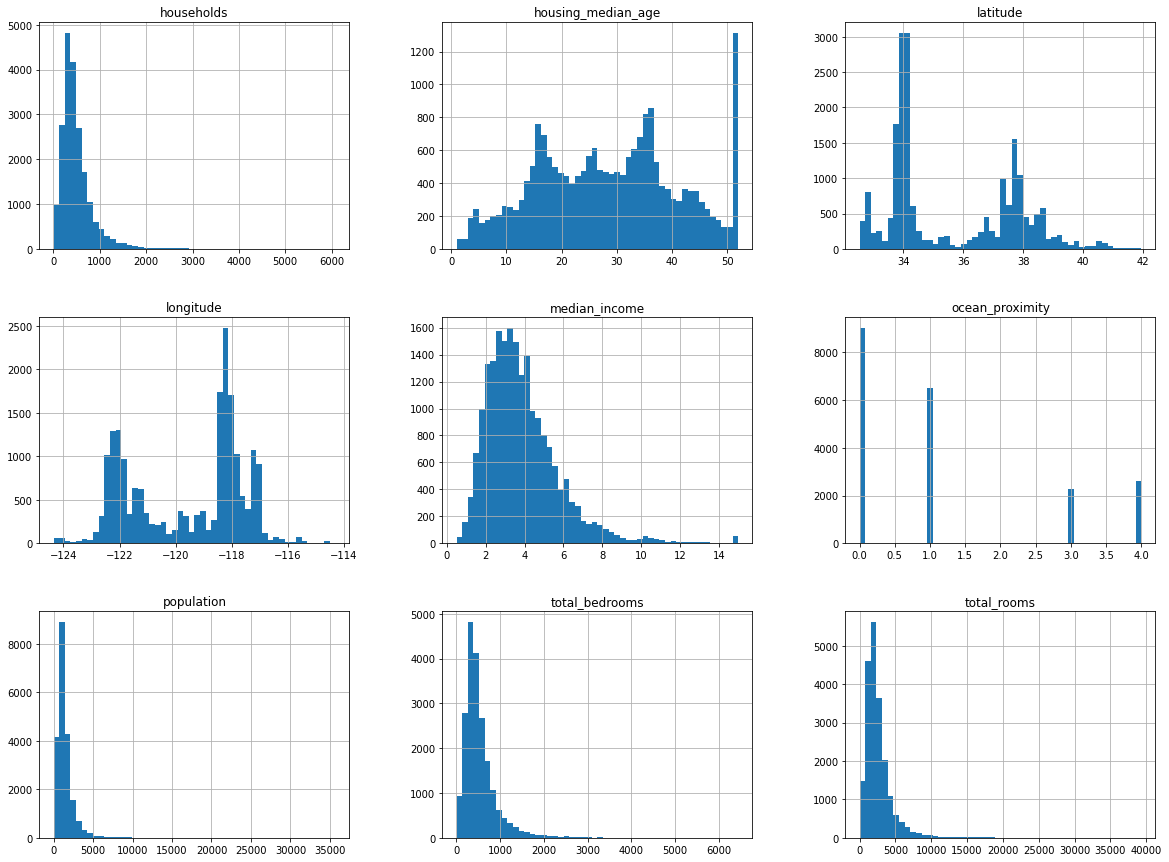

In [184]:
# Display histogram of features
df.hist(bins=50, figsize=(20, 15))

# Data Modeling

> KMeans simulation(not use AutoML)

Model score :  0.2775364376624531


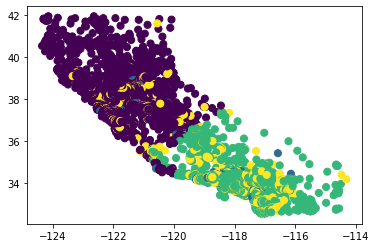

In [216]:
X = StandardScaler().fit_transform(df)
model=KMeans(n_clusters=4,random_state=1)
cluster_labels = model.fit_predict(X)
cluster_info = pd.DataFrame(cluster_labels).drop_duplicates().to_numpy().flatten()
fig, ax = plt.subplots()
# Make dataframe for each cluster
clusters_df = []
for i in range(0, len(cluster_info)):
  clusters_df.append(pd.DataFrame(columns=df.columns))
for i in range(0, len(cluster_labels)):
  clusters_df[cluster_labels[i]] = clusters_df[cluster_labels[i]].append(df.iloc[i, :])
plt.scatter(df.loc[:, 'longitude'], df.loc[:, 'latitude'], c=cluster_labels, s=50, cmap='viridis')
print("Model score : ",silhouette_score(X, cluster_labels))


> DBSCAN simulation(not use AutoML)

Model score :  -0.38553640540487577


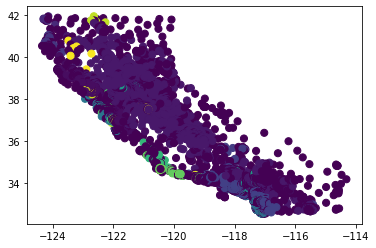

In [215]:
X = StandardScaler().fit_transform(df)
model=DBSCAN(eps=0.5,min_samples=5)
cluster_labels = model.fit_predict(X)
cluster_info = pd.DataFrame(cluster_labels).drop_duplicates().to_numpy().flatten()
fig, ax = plt.subplots()
# Make dataframe for each cluster
clusters_df = []
for i in range(0, len(cluster_info)):
  clusters_df.append(pd.DataFrame(columns=df.columns))
for i in range(0, len(cluster_labels)):
  clusters_df[cluster_labels[i]] = clusters_df[cluster_labels[i]].append(df.iloc[i, :])
plt.scatter(df.loc[:, 'longitude'], df.loc[:, 'latitude'], c=cluster_labels, s=50, cmap='viridis')
print("Model score : ",silhouette_score(X, cluster_labels))


> GaussianMixture(not use AutoML)

In [ ]:
X = StandardScaler().fit_transform(df)
model=GaussianMixture(n_components=4,random_state=10)
cluster_labels = model.fit_predict(X)
cluster_info = pd.DataFrame(cluster_labels).drop_duplicates().to_numpy().flatten()
fig, ax = plt.subplots()
# Make dataframe for each cluster
clusters_df = []
for i in range(0, len(cluster_info)):
  clusters_df.append(pd.DataFrame(columns=df.columns))
for i in range(0, len(cluster_labels)):
  clusters_df[cluster_labels[i]] = clusters_df[cluster_labels[i]].append(df.iloc[i, :])
plt.scatter(df.loc[:, 'longitude'], df.loc[:, 'latitude'], c=cluster_labels, s=50, cmap='viridis')
print("Model score : ",silhouette_score(X, cluster_labels))
  

> MeanShift(not use AutoML)

In [ ]:
X = StandardScaler().fit_transform(df)
model=MeanShift(bandwidth=0.6)
cluster_labels = model.fit_predict(X)
cluster_info = pd.DataFrame(cluster_labels).drop_duplicates().to_numpy().flatten()
fig, ax = plt.subplots()
# Make dataframe for each cluster
clusters_df = []
for i in range(0, len(cluster_info)):
  clusters_df.append(pd.DataFrame(columns=df.columns))
for i in range(0, len(cluster_labels)):
  clusters_df[cluster_labels[i]] = clusters_df[cluster_labels[i]].append(df.iloc[i, :])
plt.scatter(df.loc[:, 'longitude'], df.loc[:, 'latitude'], c=cluster_labels, s=50, cmap='viridis')
print("Model score : ",silhouette_score(X, cluster_labels))

> CLARANS(not use AutoML)

[4. 1. 2. 3.]
Model score :  0.3825719916189713


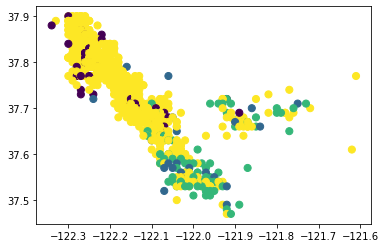

In [226]:
X = StandardScaler().fit_transform(df.iloc[:1000])
model=clarans(X.tolist(),number_clusters=4,numlocal=2,maxneighbor=3)
model.process()
cluster_labels = np.zeros(X.size // X[0].size)
for i in range(0, len(model.get_clusters())):
  for index in model.get_clusters()[i]:
    cluster_labels[index] = i + 1
fig, ax = plt.subplots()
cluster_info = pd.DataFrame(cluster_labels).drop_duplicates().to_numpy().flatten()
# Make dataframe for each cluster
clusters_df = []
for i in range(0, len(cluster_info)):
  clusters_df.append(pd.DataFrame(columns=df.columns))
for i in range(0, len(cluster_labels)):
  clusters_df[int(cluster_labels[i])-1] = clusters_df[int(cluster_labels[i])-1].append(df.iloc[i, :])
plt.scatter(df.iloc[:1000, 3], df.iloc[:1000, 2], c=cluster_labels, s=50, cmap='viridis')
print("Model score : ",silhouette_score(X, cluster_labels))

> Use AutoML

In [202]:
k_range = range(2, 11)

scaler_list = {StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler}
cluster_list = {
    # KMeans: {
    #     'n_clusters': k_range,
    #     'init': ['k-means++', 'random'],
    #     'random_state': [1]
    # },
    clarans: {
       'number_clusters': k_range,
       'numlocal': [2, 4, 6],
       'maxneighbor': [3, 5, 7]
    },
    # DBSCAN: {
    #     'eps': [1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1],
    #     'min_samples': range(2, 6)
    # },
    # GaussianMixture: {
    #     'n_components': k_range,
    #     'random_state': [1]
    # },
    # MeanShift:{
    #     'bandwidth' : [0.8,1.6,3.0]
    # }
}
method_list = {'euclidean', 'manhattan'}

output = major_function(df[:30], scaler=scaler_list, cluster=cluster_list, metric=method_list)
print(output)

[[9], [4, 19, 23], [1], [21], [0, 2, 3, 5, 13, 15, 17, 20, 25, 26, 29], [7, 8, 14], [10, 18, 24, 27, 28], [11], [6, 12, 22], [16]]
[[1], [10, 18, 24], [22], [16, 21, 23, 27, 28], [0, 5, 20, 29], [6, 8, 12, 14], [9, 11], [2, 3, 4, 15, 17, 19, 26], [7], [13, 25]]
[[4], [7, 9, 11], [6, 8, 12, 14, 22], [2, 3], [0, 5, 13, 20, 25, 29], [10, 16, 18, 24, 27, 28], [19, 21, 23], [1], [17], [15, 26]]
[[9], [6, 8, 12, 14, 22], [7], [10, 18, 24, 28], [1], [4, 19, 21, 23, 27], [16], [2, 3, 15, 17, 26], [11], [0, 5, 13, 20, 25, 29]]
[[6, 8, 12, 14, 22], [16, 21, 23, 27], [1], [2, 3], [0, 5, 20, 29], [15, 17, 26], [10, 18, 24, 28], [7, 9, 11], [13, 25], [4, 19]]
[[23], [7, 9, 11, 14], [3, 15, 17, 26], [21, 27], [0, 5, 20, 29], [13, 25], [16], [6, 8, 10, 12, 18, 22, 24, 28], [2, 4, 19], [1]]
[[0, 5], [16, 21, 23], [2, 3, 26], [13, 20, 25, 29], [8, 14], [7, 9, 11], [10, 18, 24, 27, 28], [4, 15, 17, 19], [6, 12, 22], [1]]
[[10, 18, 24], [28], [0, 5], [22], [13, 20, 25, 29], [1, 7, 9, 11], [4, 16, 23], [2

KeyboardInterrupt: ignored

# Evaluation

In [ ]:
for out in output:
  print(f'{out[0]}:{out[1].best_score_}')

# Data Modeling(SubDataset)
> Correlation Matrix Heatmap 

In [ ]:
# Drop any with how=any
dft.dropna(how='any', inplace=True)

# Method 1 - LabelEncoder, switch the categorical feature into numeric one
encoder = LabelEncoder()
dft['ocean_proximity'] = encoder.fit_transform(dft['ocean_proximity'])

# Print Correlation Matrix Heatmap
plt.figure(figsize=(15,15))
sns.heatmap(data = dft.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

# Drop 4 attributes with low correlation coefficient with median_house_value.
drop_target=dft.corr()['median_house_value'].sort_values().iloc[:4].index
print(drop_target)
dft.drop(list(drop_target), axis=1, inplace=True)

# Drop median_house_value (for clustering)
dft = dft[dft.columns.difference(['median_house_value'])]


In [ ]:
k_range = range(2, 11)

scaler_list = {StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler}
cluster_list = {
    KMeans: {
        'n_clusters': k_range,
        'init': ['k-means++', 'random'],
        'random_state': [1]
    },
    #clarans: {
    #    'number_clusters': k_range,
    #    'numlocal': [2, 4, 6],
    #    'maxneighbor': [3, 5, 7]
    #},
    # DBSCAN: {
    #     'eps': [1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1],
    #     'min_samples': range(2, 6)
    # },
    # GaussianMixture: {
    #     'n_components': k_range,
    #     'random_state': [1]
    # },
    # MeanShift:{
    #     'bandwidth' : [0.8,1.6,3.0]
    # }
}
method_list = {'euclidean', 'manhattan'}

output = major_function(dft, scaler=scaler_list, cluster=cluster_list, metric=method_list)
print(output)

# Evaluation(SubDataset)

In [ ]:
for out in output:
  print(f'{out[0]}:{out[1].best_score_}')